In [1]:
import pyvista as pv
import pandas as pd

import os

# Fichier .case
file_path = '/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/cfpdes-2d-p1.exports/Export.case'
data = pv.read(file_path)

# Extraire les données de chaque bloc
for i, block in enumerate(data):
    if block is None:
        continue
    print(f"Bloc {i}:")
    print(block)

    print("Champs de points disponibles:", block.point_data.keys())
    print("Champs de cellules disponibles:", block.cell_data.keys())

    solution = 'cfpdes.poisson.u'

    if solution in block.point_data.keys(): 
        solution_expression = block.point_data[solution]
        print("Expression de la fonction extraite:", solution_expression)
    else:
        print(f"Le champ '{solution}' n'existe pas dans les données de points du bloc {i}.")

    df = pd.DataFrame(block.point_data)
    print(df.head())


Bloc 0:
UnstructuredGrid (0x7faf0aebc760)
  N Cells:    248
  N Points:   145
  X Bounds:   0.000e+00, 1.000e+00
  Y Bounds:   0.000e+00, 1.000e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   5
Champs de points disponibles: ['cfpdes.expr.grad_u_exact', 'cfpdes.expr.rhs', 'cfpdes.expr.u_exact', 'cfpdes.poisson.u']
Champs de cellules disponibles: ['cfpdes.pid']
Expression de la fonction extraite: [0.07331746 0.05776875 0.08262263 0.02188804 0.01424703 0.03132632
 0.03862159 0.05665331 0.02713028 0.03025533 0.13267705 0.13555463
 0.12985344 0.05180994 0.04122949 0.06839477 0.12255649 0.12535216
 0.1065937  0.12271012 0.11776266 0.10061184 0.01403364 0.06273852
 0.03245225 0.03940221 0.0300367  0.05201454 0.11290917 0.08112058
 0.07964544 0.05826703 0.05814137 0.08193369 0.1182636  0.01990779
 0.02418072 0.06122256 0.05372437 0.10325091 0.10095716 0.04881165
 0.08206823 0.04415213 0.04129555 0.05099648 0.08675424 0.1128277
 0.09783896 0.11045535 0.07437901 0.05899265 0.         0.0777

In [2]:
poisson_u = block.point_data['cfpdes.poisson.u']
print("Valeurs de 'cfpdes.poisson.u':")
print(poisson_u[:10])  # Affiche les 10 premières valeurs pour un aperçu


Valeurs de 'cfpdes.poisson.u':
[0.07331746 0.05776875 0.08262263 0.02188804 0.01424703 0.03132632
 0.03862159 0.05665331 0.02713028 0.03025533]


In [3]:
import os
import feelpp
from feelpp.toolboxes.cfpdes import *
from tools.lap2D_pinns import Run_laplacian2D, Poisson_2D, PoissonDisk2D
from scimba.equations import domain
from tools.GeoToMsh import geo_to_msh
from tools.GmeshRead import mesh2d
from tools.cmap import custom_cmap

import pandas as pd
import numpy as np
import pyvista as pv

import plotly.express as px
from plotly.subplots import make_subplots
import itertools
import torch
from pathlib import Path

class Poisson_feel:
  """
  Solves the problem
  -Laplacian u = f   in Omega
  u            = g   in boundary
  
  - with f,g are set by the user
  """
  def __init__(self, dim=2, order=1):

    self.dim   = dim
    self.model = dict()
    self.order = order  
##______________________________________________________________________________________________

  def genCube(self, filename, h=0.1):
    """
    Generate a cube geometry following the dimension  self.dim
    """

    
    geo="""SetFactory("OpenCASCADE");
    h={};
    dim={};
    """.format(h, self.dim)
    
    if self.dim==2 :
      geo+="""
      Rectangle(1) = {0, 0, 0, 1, 1, 0};
      Characteristic Length{ PointsOf{ Surface{1}; } } = h;
      Physical Curve("Gamma_D") = {1,2,3,4};
      Physical Surface("Omega") = {1};
      """
    elif self.dim==3 :
      geo+="""
      Box(1) = {0, 0, 0, 1, 1, 1};
      Characteristic Length{ PointsOf{ Volume{1}; } } = h;
      Physical Surface("Gamma_D") = {1,2,3,4,5,6};
      Physical Volume("Omega") = {1};
      """
    with open(filename, 'w') as f:
      f.write(geo)

##______________________________________________________________________________________________

  def getMesh(self, filename,hsize=0.05,dim=2,verbose=False):
    """create mesh

    Args:
        filename (str): name of the file
        hsize (float): mesh size
        dim (int): dimension of the mesh
        verbose (bool): verbose mode
    """
    import os
    for ext in [".msh",".geo"]:
      f=os.path.splitext(filename)[0]+ext
      if os.path.exists(f):
        os.remove(f)
    if verbose:
      print(f"generate mesh {filename} with hsize={hsize} and dimension={dim}")
    self.genCube(filename=filename, h=hsize)
    mesh = feelpp.load(feelpp.mesh(dim=dim,realdim=dim), filename, hsize)
    return mesh

##______________________________________________________________________________________________

  def feel_solver(self, filename, h, json, dim=2,verbose=False):
    if verbose:
      print(f"Solving the laplacian problem for hsize = {h}...")
    self.pb.setMesh(self.getMesh(filename,hsize=h,dim=dim,verbose=verbose))
    self.pb.setModelProperties(json)
    self.pb.init(buildModelAlgebraicFactory=True)
    self.pb.printAndSaveInfo()
    self.pb.solve()
    self.pb.exportResults()
    measures = self.pb.postProcessMeasures().values()
    return measures
  
##______________________________________________________________________________________________

  
  def __call__(self,
               h=0.1,                                       # mesh size 
               order=1,                                 # polynomial order 
               name='u',                                # name of the variable u
               rhs='8*pi*pi*sin(2*pi*x)*sin(2*pi*y)',   # right hand side
               diff='{1,0,0,1}',                        # diffusion matrix
               g='0',
               geofile=None,
               plot=None,
               solver='feelpp',
               u_exact='sin(2 * pi * x) * sin(2 * pi * y)',
               grad_u_exact = '{2*pi*cos(2*pi*x)*sin(2*pi*y),2*pi*sin(2*pi*x)*cos(2*pi*y)}' 
               ):
    """
    Solves the problem where :
    - h is the mesh size
    - order the polynomial order
    - rhs is the expression of the right-hand side f(x,y)
    """
    self.measures = dict()
    self.rhs = rhs
    self.g = g
    self.u_exact = u_exact
    self.diff = diff
    self.pb    = cfpdes(dim=self.dim, keyword=f"cfpdes-{self.dim}d-p{self.order}")
    self.model = {
      "Name": "Laplacian",
      "ShortName": "Laplacian",
      "Models":
      {
        f"cfpdes-{self.dim}d-p{self.order}":
        {
          "equations":"poisson"
        },
        "poisson":{
          "setup":{
            "unknown":{
              "basis":f"Pch{order}",
              "name":f"{name}",
              "symbol":"u"
            },
            "coefficients":{
              "c": f"{diff}:x:y" if self.dim == 2 else f"{diff}:x:y:z",
              "f": f"{rhs}:x:y"  if self.dim == 2 else f"{rhs}:x:y:z"
            }
          }
        }
      },
      "Materials":
      {
        "Omega":
        {
          "markers":["Omega"]
        }
      },
      "BoundaryConditions":
      {
        "poisson":
        {
          "Dirichlet":
          {
            "g":
            {
              "markers":["Gamma_D"],
              "expr":f"{g}:x:y"
            }
          }
        }
      },
      "PostProcess":
      {
        f"cfpdes-{self.dim}d-p{self.order}":
        {
          "Exports":
          {
            "fields":["all"],
            "expr":{
              "rhs": f"{rhs}:x:y" if self.dim == 2 else f"{rhs}:x:y:z",
              "u_exact" : f"{u_exact}:x:y" if self.dim==2 else f"{u_exact}:x:y:z",
              "grad_u_exact" : f"{grad_u_exact}:x:y" if self.dim==2 else f"{grad_u_exact}:x:y:z",
            }
          },
            "Measures" :
            {
              "Norm" :
              {
                  "poisson" :
                  {
                     "type":["L2-error", "H1-error"],
                     "field":f"poisson.{name}",
                     "solution": f"{u_exact}:x:y" if self.dim==2 else f"{u_exact}:x:y:z",
                     "grad_solution": f"{grad_u_exact}:x:y" if self.dim==2 else f"{grad_u_exact}:x:y:z",
                     "markers":"Omega",
                     "quad":6
                 }
              },
                "Statistics":
                {
                    "mystatA":
                    {
                        "type":["min","max","mean","integrate"],
                        "field":f"poisson.{name}"
                    }
                }
            }
        }
      }
    }

    fn = None
    if geofile is None:
      fn = f'omega-{self.dim}.geo'
      self.genCube(fn, h)
    else:
      fn = geofile      
##________________________

  # Solving

    if solver == 'feelpp':
      self.measures = self.feel_solver(filename=fn, h=h, json=self.model, dim=self.dim, verbose=True)
##________________________

     
    # Plots
    if plot != None:
      
      from xvfbwrapper import Xvfb
      import pyvista as pv 
      import matplotlib.pyplot as plt


      vdisplay = Xvfb()
      vdisplay.start()
      pv.set_jupyter_backend('static') 
      #pv.start_xvfb()
      def pv_get_mesh(mesh_path):
          reader = pv.get_reader(mesh_path)
          mesh = reader.read()
          return mesh

      def pv_plot(mesh, field, clim=None, cmap=custom_cmap, cpos='xy', show_scalar_bar=True, show_edges=True):
          mesh.plot(scalars=field, clim=clim, cmap=cmap, cpos=cpos, show_scalar_bar=show_scalar_bar, show_edges=show_edges)

      def myplots(dim=2, field=f"cfpdes.poisson.{name}", factor=1, cmap=custom_cmap):
          mesh = pv_get_mesh((f"cfpdes-{self.dim}d-p{self.order}.exports/Export.case"))
          #pv_plot(mesh, field)
          pl = pv.Plotter(shape=(1,2))

          pl.add_title(f'Solution P{order}', font_size=18)
          pl.add_mesh(mesh[0], scalars = f"cfpdes.poisson.{name}", cmap=custom_cmap)

          pl.subplot(0,1)
          pl.add_title('u_exact=' + u_exact, font_size=10)
          pl.add_mesh(mesh[0].copy(), scalars = 'cfpdes.expr.u_exact', cmap=custom_cmap)

          
          pl.link_views()
          pl.view_xy()
          pl.show()
          pl.screenshot(plot)

      myplots(dim=2,factor=0.5)


Using device: cpu
torch loaded; device is cpu
Info    : Reading '/workspaces/2024-m1-scimba-feelpp/geo/disk.geo'...
Info    : Done reading '/workspaces/2024-m1-scimba-feelpp/geo/disk.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000365275s, CPU 0.003752s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0144673s, CPU 0.013781s)
Info    : 144 nodes 290 elements
Info    : Writing '/workspaces/2024-m1-scimba-feelpp/geo/disk.msh'...
Info    : Done writing '/workspaces/2024-m1-scimba-feelpp/geo/disk.msh'


-pyvista export.case extraire certaines solutions

In [4]:
import sys
import feelpp
import feelpp.toolboxes.core as tb

# mandatory things
sys.argv = ["feelpp_app"]
e = feelpp.Environment(sys.argv,
                       opts=tb.toolboxes_options("coefficient-form-pdes", "cfpdes"),
                       config=feelpp.localRepository('feelpp_cfpde'))

# ------------------------------------------------------------------------- #
# Poisson problem
# - div (diff * grad (u)) = f    in Omega
#                     u   = g    in Gamma_D
# Omega = domain, either cube or ball
# Approx = lagrange Pk of order order
# mesh of size h



[ Starting Feel++ ] application feelpp_app version 0.1 date 2024-Jun-04
 . feelpp_app files are stored in /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1
 .. logfiles :/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/logs


In [5]:
mesh = '/workspaces/2024-m1-scimba-feelpp/geo/disk.msh'
my_mesh = mesh2d(mesh)
my_mesh.read_mesh()
coordinates = my_mesh.Nodes
print(coordinates)
scalars = "cfpdes.poisson.u"
print(scalars)

[[0.         0.        ]
 [1.         0.        ]
 [1.         1.        ]
 [0.         1.        ]
 [0.1        0.        ]
 [0.2        0.        ]
 [0.3        0.        ]
 [0.4        0.        ]
 [0.5        0.        ]
 [0.6        0.        ]
 [0.7        0.        ]
 [0.8        0.        ]
 [0.9        0.        ]
 [1.         0.1       ]
 [1.         0.2       ]
 [1.         0.3       ]
 [1.         0.4       ]
 [1.         0.5       ]
 [1.         0.6       ]
 [1.         0.7       ]
 [1.         0.8       ]
 [1.         0.9       ]
 [0.9        1.        ]
 [0.8        1.        ]
 [0.7        1.        ]
 [0.6        1.        ]
 [0.5        1.        ]
 [0.4        1.        ]
 [0.3        1.        ]
 [0.2        1.        ]
 [0.1        1.        ]
 [0.         0.9       ]
 [0.         0.8       ]
 [0.         0.7       ]
 [0.         0.6       ]
 [0.         0.5       ]
 [0.         0.4       ]
 [0.         0.3       ]
 [0.         0.2       ]
 [0.         0.1       ]


Solving the laplacian problem for hsize = 0.1...
generate mesh omega-2.geo with hsize=0.1 and dimension=2


[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.1 
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                                                                |
| | Environment                                                                    

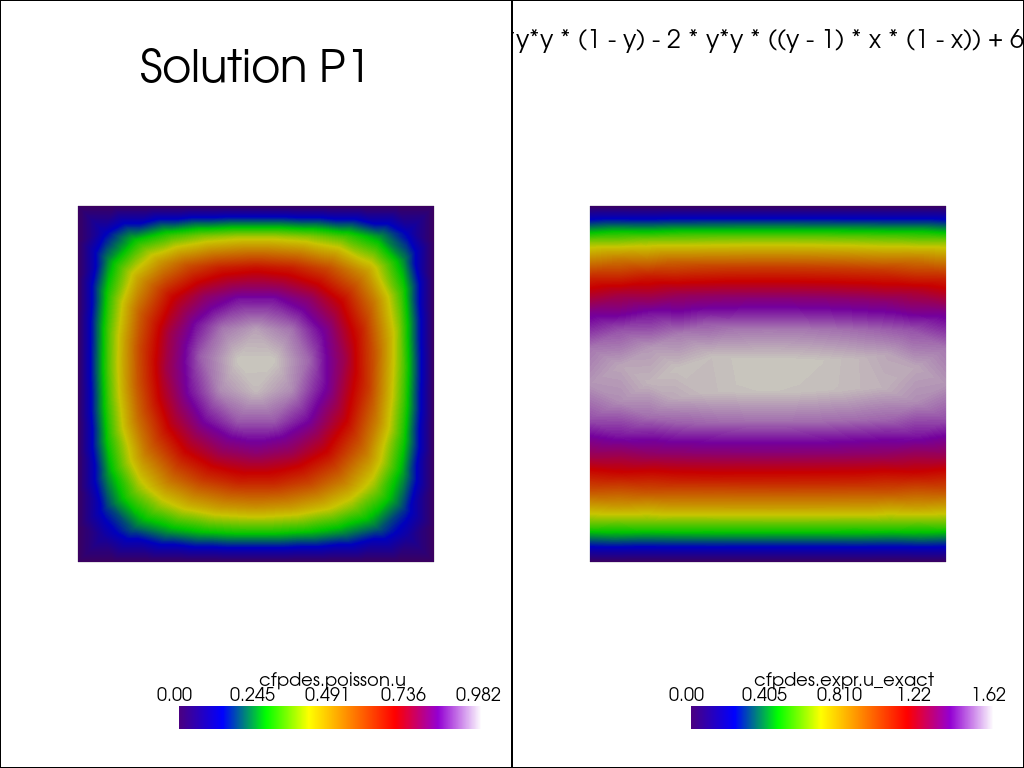

{'Norm_poisson_H1-error': 5.152468685191792, 'Norm_poisson_L2-error': 0.7055794974468532, 'Statistics_mystatA_integrate': 0.46417422813909154, 'Statistics_mystatA_max': 0.9809242262426827, 'Statistics_mystatA_mean': 0.4641742281390914, 'Statistics_mystatA_min': 0.005541442384105216}


In [6]:
u_exact = 'y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)'
rhs='-2 * (-6 + x * (2 - 6 * y) + 3 * y - 8 * y*y + 2 * y*y*y + x*x * (-2 + 6 * y))'

P = Poisson_feel(dim = 2)
P(rhs=rhs, g='0', order=1, plot='f4.png', u_exact = u_exact)
#P(rhs=rhs, g='0', order=1, solver='scimba', u_exact = u_exact)
print(P.measures)


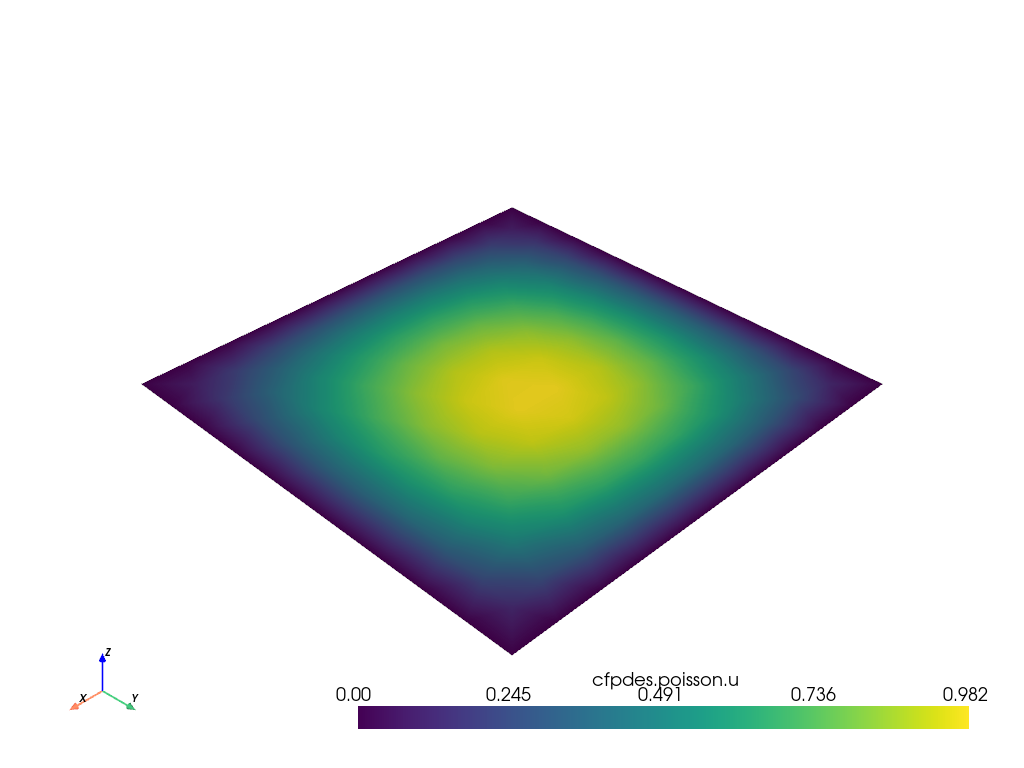

In [7]:
reader = pv.get_reader('/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/cfpdes-2d-p1.exports/Export.case')
mesh = reader.read()
mesh.plot(scalars = f"cfpdes.poisson.u")

In [8]:
def runLaplacianPk(P, df, model, verbose=False):
    """Generate the Pk case"""
    meas = dict()
    dim, order, json = model
    fn = f'omega-{P.dim}.geo'
    
    for h in df['h']:
        P.genCube(fn, h)
        m = P.measures #P.feel_solver(filename=fn, h=h, json=json, dim=dim, verbose=verbose)
        if m is None:
            print(f"Warning: Solver returned None for h={h}")
            continue

        for norm in ['L2', 'H1']:
            error_key = f'Norm_poisson_{norm}-error'
            if error_key not in m:
                print(f"Warning: '{error_key}' not found in solver output")
                continue

            meas.setdefault(f'P{order}-Norm_poisson_{norm}-error', [])
            meas[f'P{order}-Norm_poisson_{norm}-error'].append(m[error_key])

    df = df.assign(**meas)

    # Calculate convergence rates where possible
    for norm in ['L2', 'H1']:
        error_series = f'P{order}-Norm_poisson_{norm}-error'
        if error_series in df and len(df[error_series]) > 1:
            rate_series = f'P{order}-poisson_{norm}-convergence-rate'
            rates = np.log2(df[error_series].shift() / df[error_series]) / np.log2(df['h'].shift() / df['h'])
            df[rate_series] = rates.fillna(0)  # Replace NaNs with zero or another suitable value

    return df
def runConvergenceAnalysis(P, json,dim=2,hs=[0.1,0.05,0.025],order='1',verbose=False):
  df=pd.DataFrame({'h':hs})
  df=runLaplacianPk(P, df=df,model=[dim,order,json(dim=dim,order=order)],verbose=verbose)
  print(df.to_markdown())
  return df

#laplacian_json = lambda order,dim=2,name="u": P.model
#df= runConvergenceAnalysis(P, json=laplacian_json,dim=2,verbose=True)



def plot_convergence(P, df,dim,orders=[1]):
  fig=px.line(df, x="h", y=[f'P{order}-Norm_poisson_{norm}-error' for order,norm in list(itertools.product(orders,['L2','H1']))])
  fig.update_xaxes(title_text="h",type="log")
  fig.update_yaxes(title_text="Error",type="log")
  for order,norm in list(itertools.product(orders,['L2','H1'])):
    fig.update_traces(name=f'P{order} - {norm} error - {df[f"P{order}-poisson_{norm}-convergence-rate"].iloc[-1]:.2f}', selector=dict(name=f'P{order}-Norm_poisson_{norm}-error'))
  fig.update_layout(
          title=f"Convergence rate for the {dim}D Laplacian problem",
          autosize=False,
          width=900,
          height=900,
      )
  return fig
#fig= plot_convergence(P, df,dim=2)
#fig.show()



Solving the laplacian problem for hsize = 0.1...
generate mesh omega-2.geo with hsize=0.1 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.1 
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                                               |
| | Environment                              

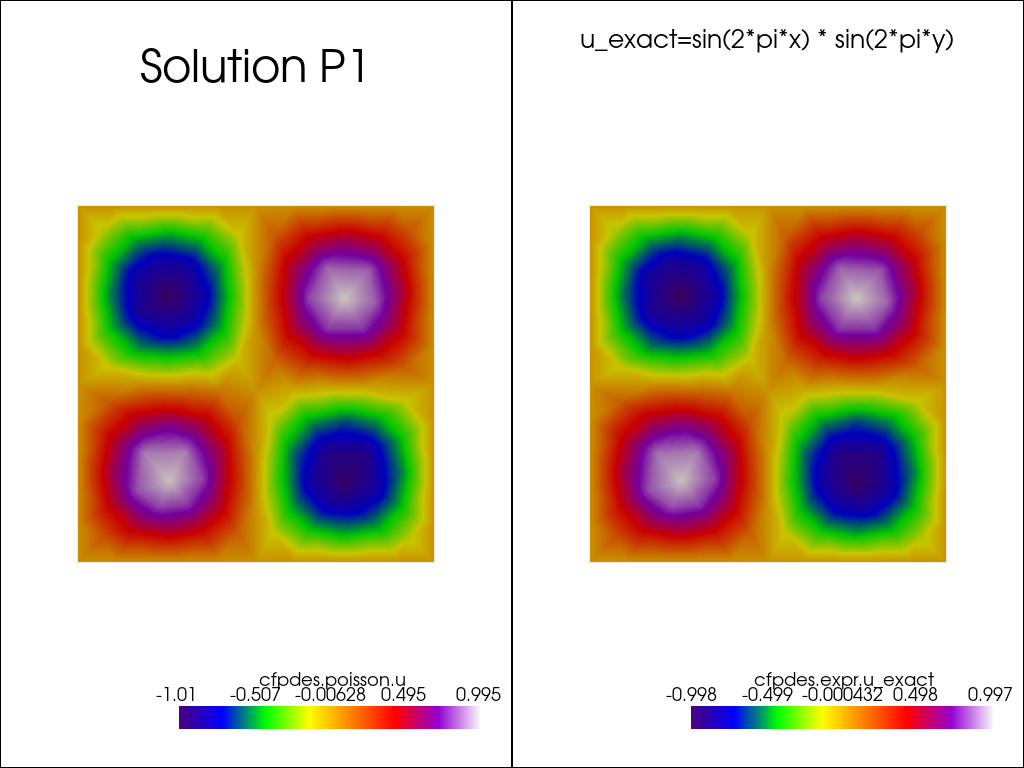

[2, 1, {'Name': 'Laplacian', 'ShortName': 'Laplacian', 'Models': {'cfpdes-2d-p1': {'equations': 'poisson'}, 'poisson': {'setup': {'unknown': {'basis': 'Pch1', 'name': 'u', 'symbol': 'u'}, 'coefficients': {'c': '{1,0,0,1}:x:y', 'f': '8*pi*pi*sin(2*pi*x) * sin(2*pi*y):x:y'}}}}, 'Materials': {'Omega': {'markers': ['Omega']}}, 'BoundaryConditions': {'poisson': {'Dirichlet': {'g': {'markers': ['Gamma_D'], 'expr': '0:x:y'}}}}, 'PostProcess': {'cfpdes-2d-p1': {'Exports': {'fields': ['all'], 'expr': {'rhs': '8*pi*pi*sin(2*pi*x) * sin(2*pi*y):x:y', 'u_exact': 'sin(2*pi*x) * sin(2*pi*y):x:y', 'grad_u_exact': '{2*pi*cos(2*pi*x)*sin(2*pi*y),2*pi*sin(2*pi*x)*cos(2*pi*y)}:x:y'}}, 'Measures': {'Norm': {'poisson': {'type': ['L2-error', 'H1-error'], 'field': 'poisson.u', 'solution': 'sin(2*pi*x) * sin(2*pi*y):x:y', 'grad_solution': '{2*pi*cos(2*pi*x)*sin(2*pi*y),2*pi*sin(2*pi*x)*cos(2*pi*y)}:x:y', 'markers': 'Omega', 'quad': 6}}, 'Statistics': {'mystatA': {'type': ['min', 'max', 'mean', 'integrate'], '

In [9]:

u_exact = 'sin(2*pi*x) * sin(2*pi*y)'
rhs = '8*pi*pi*sin(2*pi*x) * sin(2*pi*y)'

P(rhs=rhs, g='0', order=1, plot='f2.png', u_exact = u_exact)
laplacian_json = lambda order,dim=2,name="u": P.model

with open(f'poisson-{P.dim}d.json', 'w') as f:
      # Write the string to the file
      import json
      f.write(json.dumps(laplacian_json(dim=P.dim,order=1),indent=1))
      # execute the laplacian problem using P1 basis on a mesh of the unit square  of size 0.1

json=laplacian_json

model=[P.dim,P.order,json(dim=P.dim,order=P.order)]
print(model)
hs=[0.1,0.05,0.025,0.0125]
df=pd.DataFrame({'h':hs})


df= runLaplacianPk(P, df=df, model=model, verbose=True)
df= runConvergenceAnalysis( P, json=json,dim=2,verbose=True)


In [10]:
fig= plot_convergence(P, df,dim=2)
fig.show()



Solving the laplacian problem for hsize = 0.1...
generate mesh omega-2.geo with hsize=0.1 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.1 
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                                               |
| | Environment                              

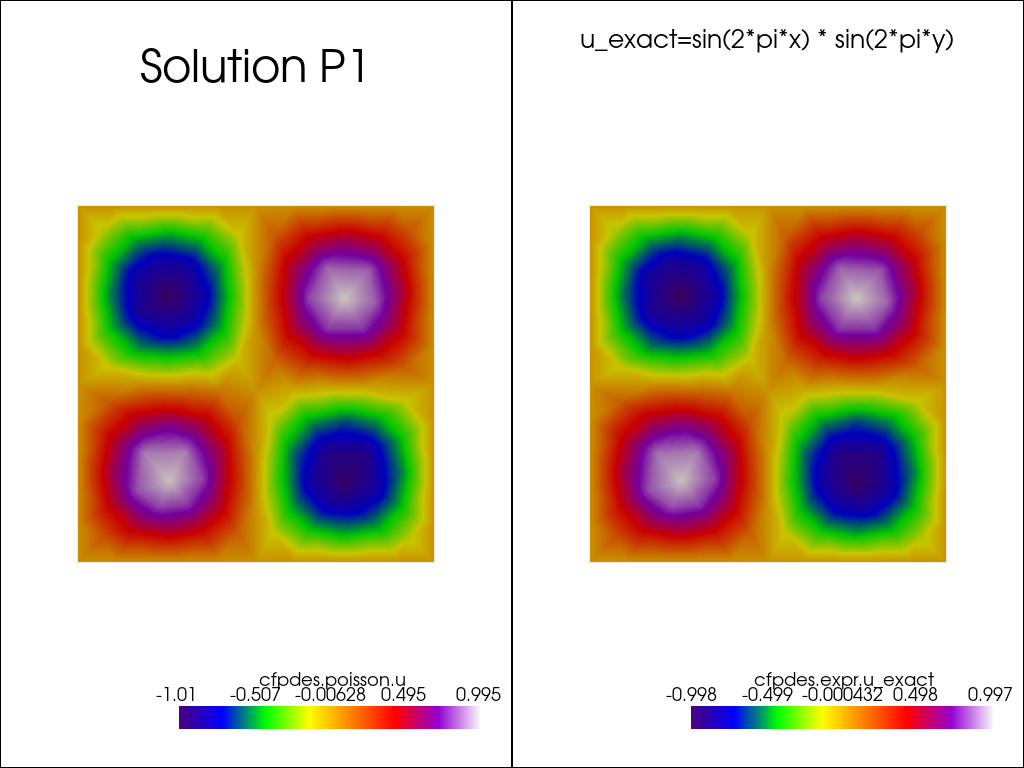

Solving the laplacian problem for hsize = 0.1...
generate mesh /workspaces/2024-m1-scimba-feelpp/geo/disk.geo with hsize=0.1 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/geo/disk.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/geo/disk.geo 0.1 
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                                                           |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                                 

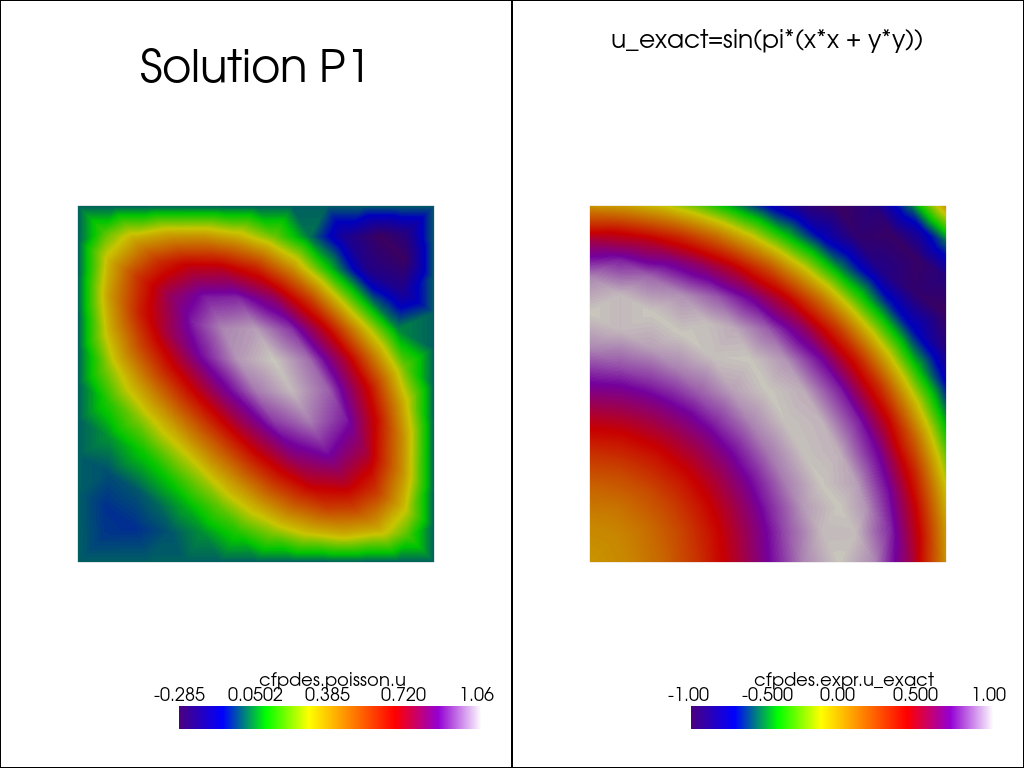

In [11]:



# 2D on different domains
# for square domain
u_exact = 'sin(2*pi*x) * sin(2*pi*y)'
rhs = '8*pi*pi*sin(2*pi*x) * sin(2*pi*y)'

P(rhs=rhs, g='0', order=1, plot='f2.png', u_exact = u_exact)
P(rhs=rhs, g='0', order=1, solver ='scimba', u_exact = u_exact)

# for disk domain
u_exact =  'sin(pi*(x*x + y*y))'
rhs = '4* pi * (-cos(pi* (x*x + y*y)) + pi * (x*x + y*y)* sin(pi* (x*x + y*y)))'
P(rhs=rhs, g='0', order=1, geofile='/workspaces/2024-m1-scimba-feelpp/geo/disk.geo', solver='scimba', u_exact = u_exact)
P(rhs=rhs, g='0', order=1, geofile='/workspaces/2024-m1-scimba-feelpp/geo/disk.geo', plot='2d.png', u_exact = u_exact)





Solving the laplacian problem for hsize = 0.1...
generate mesh omega-2.geo with hsize=0.1 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.1 
+------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                             |
+------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                           |
| | Environment                                                                          |                                   

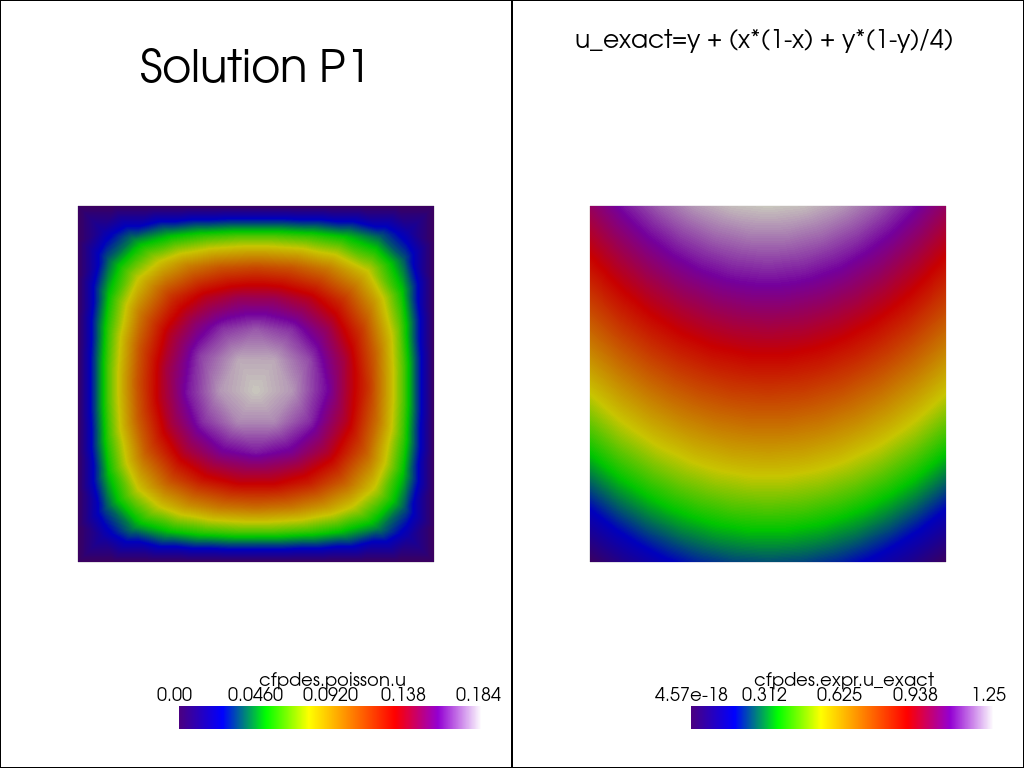

"\n\nP( rhs='-1.0-3*y*x+y*y', g='y', order=1, plot='f3.png')\nP( rhs='-1.0-3*y*x+y*y', g='y', order=1, solver ='scimba')\n\n\nP( rhs='-1.0-4*y*x+y*y', g='x', order=1, plot='f4.png')\nP( rhs='-1.0-4*y*x+y*y', g='x', order=1, solver ='scimba')\n\n"

In [12]:

u_exact = 'y + (x*(1-x) + y*(1-y)/4) '
P(rhs='5/2',              g='0', order=1, plot='f5.png', u_exact = u_exact)
P(rhs='5/2',              g='0', order=1, solver ='scimba', u_exact = u_exact)


"""

P( rhs='-1.0-3*y*x+y*y', g='y', order=1, plot='f3.png')
P( rhs='-1.0-3*y*x+y*y', g='y', order=1, solver ='scimba')


P( rhs='-1.0-4*y*x+y*y', g='x', order=1, plot='f4.png')
P( rhs='-1.0-4*y*x+y*y', g='x', order=1, solver ='scimba')

"""


Solving the laplacian problem for hsize = 0.1...
generate mesh omega-2.geo with hsize=0.1 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.1 
+---------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                |
+---------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                              |
| | Environment                                                                          |                       

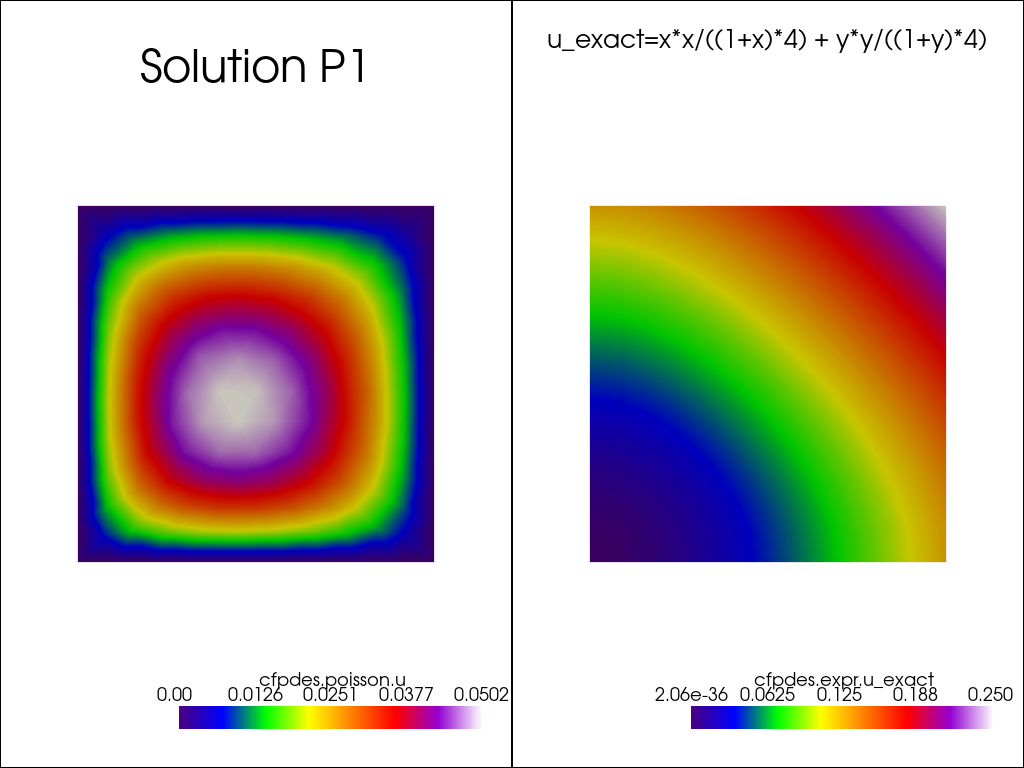

Solving the laplacian problem for hsize = 0.1...
generate mesh omega-2.geo with hsize=0.1 and dimension=2
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.1 
+--------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                               |
+--------------------------------------------------------------------------------------------------------------------------------------+
| +--------------------------------------------------------------------------------------+                                             |
| | Environment                                                                          |                           

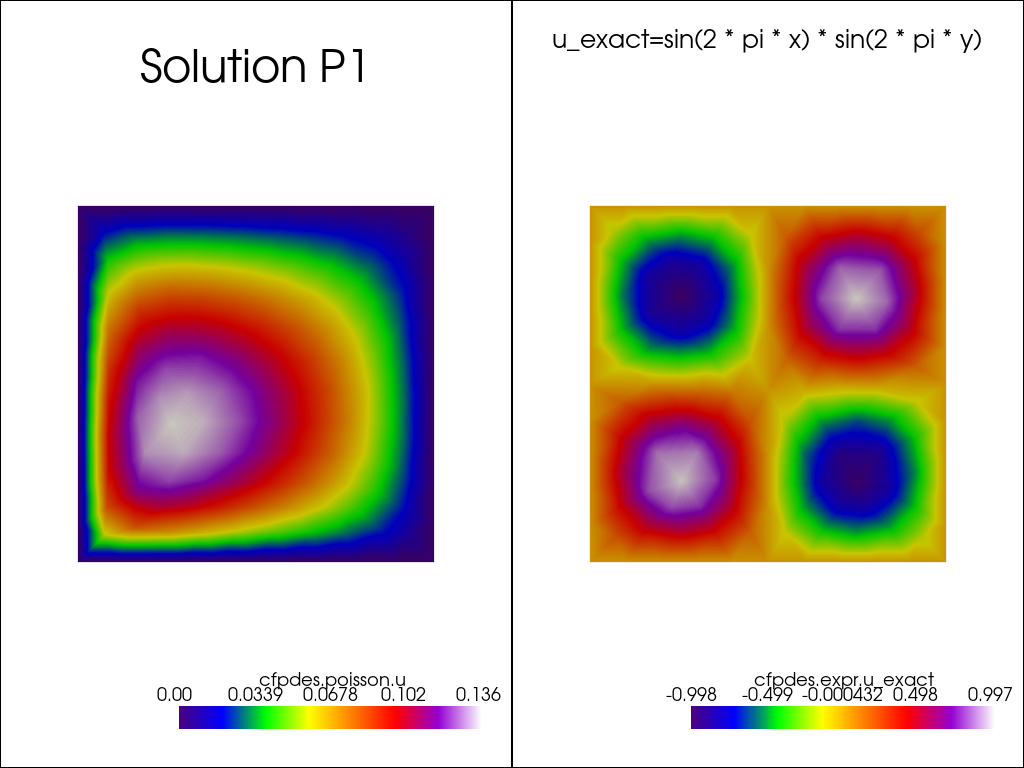

In [13]:


# # 2D with varying anisotropy
u_exact = 'x*x/((1+x)*4) + y*y/((1+y)*4)'
P(rhs='1', diff='{1+x,0,0,1+y}', plot='d1.png', u_exact = u_exact)
P(rhs='1+ x-x', diff='(1+x,0,0,1+y)', solver='scimba', u_exact = u_exact)

P(rhs='1', diff='{x,y,-y,x+y}',  plot='d3.png')
P(rhs='1+ x-x', diff='(x,y,-y,x+y)',  solver='scimba')

